# Detecção de Fraudes em Cartões de Crédito

O problema das fraudes em cartões de crédito é uma das principais preocupações das instituições financeiras, já que essas fraudes podem causar prejuízos significativos para os consumidores e para as próprias instituições. Além disso, a detecção de fraudes pode ser um desafio, já que os fraudadores estão constantemente buscando maneiras de evadir os sistemas de segurança. Segundo dados da Serasa Experian, apenas no Brasil, cerca de **12,1 milhões de pessoas foram vítimas** de algum tipo de fraude financeira no último ano, representando um **prejuízo de 1,8 bilhão de reais** para os últimos 12 meses. 

Detectar fraudes em cartões de crédito pode ser um desafio, já que as transações legítimas e as fraudulentas podem se parecer muito entre si. Além disso, as fraudes podem ocorrer em uma ampla gama de valores e locais, tornando difícil identificar um padrão. Isso pode levar a erros de detecção, tanto em falsos positivos (bloqueio preventivo do cartão do consumidor) quanto em falsos negativos (não detecção de uma transação fraudulenta).

<p align = "center">
<img src="Arquivos/fraud.jpg" width=80%>
</p>

**O objetivo deste projeto é realizar uma análise exploratória dos dados de transações com cartões de crédito e construir modelos de machine learning capazes de detectar transações fraudulentas com alta precisão.** Para isso, será necessário utilizar técnicas avançadas de análise de dados e machine learning para identificar padrões e anomalias nos dados, bem como técnicas de balanceamento de dados. Além disso, será importante avaliar a eficácia dos modelos construídos, tanto em termos de precisão na detecção de fraudes quanto em relação à quantidade de falsos positivos.

## Importando os Dados

Os dados que usaremos neste projeto foram disponibilizados por algumas empresas européias de cartão de crédito. O *dataset* representa as operações financeiras que aconteceram no período de dois dias, onde foram classificadas 492 fraudes em meio a quase 290 mil transações. Este é um conjunto de dados extremamente desbalanceado, onde as fraudes representam apenas 0,17% do total.

Outro detalhe interessante é que as *features* são todas numéricas, e foram descaracterizadas (por problemas ligados à privacidade e segurança). Assim, os nomes das colunas são representados por $[V1, V2, V3 \dots, V28]$.

In [483]:
# importar os pacotes necessários

import os
import graphviz
import numpy as np
import pandas as pd
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt


from sklearn import tree
from sklearn.cluster import KMeans
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.tree import export_graphviz
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import ClusterCentroids
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

In [484]:
file_path = "https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1"

# importar os dados para um dataframe
df = pd.read_csv(file_path)

## Análise dos Dados

Esta etapa tem por objetivo permitir um entendimento de como os dados estão estruturados.

**Dicionário das variáveis**
* `Time` - contém o número de segundos decorridos entre a primeira transação e a transação atual.
* `V1, V2, ..., V28` - colunas numéricas anônimas que contêm características do tipo PCA (Principal Component Analysis) transformadas. Infelizmente, devido a questões de privacidade, não podemos saber o significado exato dessas características.
* `Amount` - contém o valor da transação.
* `Class` - é a coluna de destino e contém 0 para transações normais e 1 para transações fraudulentas.

## Análise Exploratória dos Dados

Na análise exploratória de dados será efetuada uma explanação inicial das variáveis contidas na dataset, e entenderemos dados referentes a [...]:

* *Contexto geral das variáveis*
* *Porcentagem de itens nulos*
* *Balanceamento do dataset*
* *Análise do tempo decorrido entre as transações*
* *Análise do valor contido na transação*
* *Relação entre tempo e valor da transação*


Primeiramente, observaremos como estão dispostas as cinco primeiras entradas do dataset para ter uma visão ampla da estrutura de dados.

In [485]:
# Ver as 5 primeiras entradas
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [486]:
# Visualizar o tamanho do dataframe
print("Entradas: ", df.shape[0])
print("Variáveis: ", df.shape[1])

Entradas:  284807
Variáveis:  31


In [487]:
# Extrair o nome das colunas
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [488]:
# Extrair o tipo das variáveis
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [489]:
# Porcentagem de itens nulos
(df.isnull().sum()/df.shape[0]).sort_values(ascending = True) * 100

Time      0.0
V28       0.0
V27       0.0
V26       0.0
V25       0.0
V24       0.0
V23       0.0
V22       0.0
V21       0.0
V20       0.0
V19       0.0
V18       0.0
V17       0.0
V16       0.0
Amount    0.0
V15       0.0
V13       0.0
V12       0.0
V11       0.0
V10       0.0
V9        0.0
V8        0.0
V7        0.0
V6        0.0
V5        0.0
V4        0.0
V3        0.0
V2        0.0
V1        0.0
V14       0.0
Class     0.0
dtype: float64

Podemos observar que **não há itens nulos em nenhuma variável**, o que é um ponto positivo para a análise. Contudo, as variáveis `Amount` e `Time` estão numa ordem de grandeza diferente, logo precisarão ser **normalizados**.
Iremos agorar plotar um gráfico de barras para observar o balanceamento da dataset. 

In [490]:
# Quantidade de dados distribuidos por classes
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

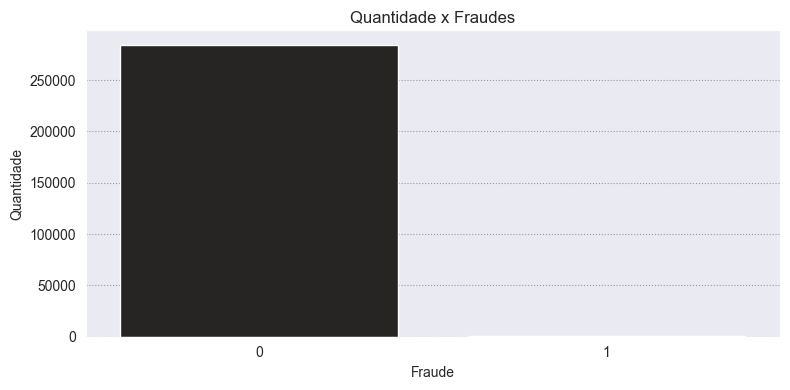

In [491]:
# Plotar um gráfico de barras para ver o balanceamento do *dataset*
fig, ax = plt.subplots(figsize=(8, 4))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_palette(sns.dark_palette("xkcd:golden", 8))
count = df['Class'].value_counts()
sns.countplot(x='Class', data=df)
ax.set_xlabel('Fraude')
ax.set_ylabel('Quantidade')
ax.set_title('Quantidade x Fraudes');
plt.tight_layout()

O dataset é altamente **desbalanceado**, com apenas 0,172% das transações sendo fraudulentas. Uma consequência de ter dados desbalanceados é um **modelo enviesado**, que privilegia a classe maioritária. No escopo do problema, detectar transações normais corretamente, mas não detectar fraudes causa enormes prejuízos. Logo, é necessário um **balanceamento** a fim de construir um modelo eficaz ao problema.

A seguir um histograma para a variável `Time`quando há fraudes e quando não há. Podemos observar um pico em 100000 segundos quando há fraudes, ao contrário de transações normais em que esse valor é diminuto.

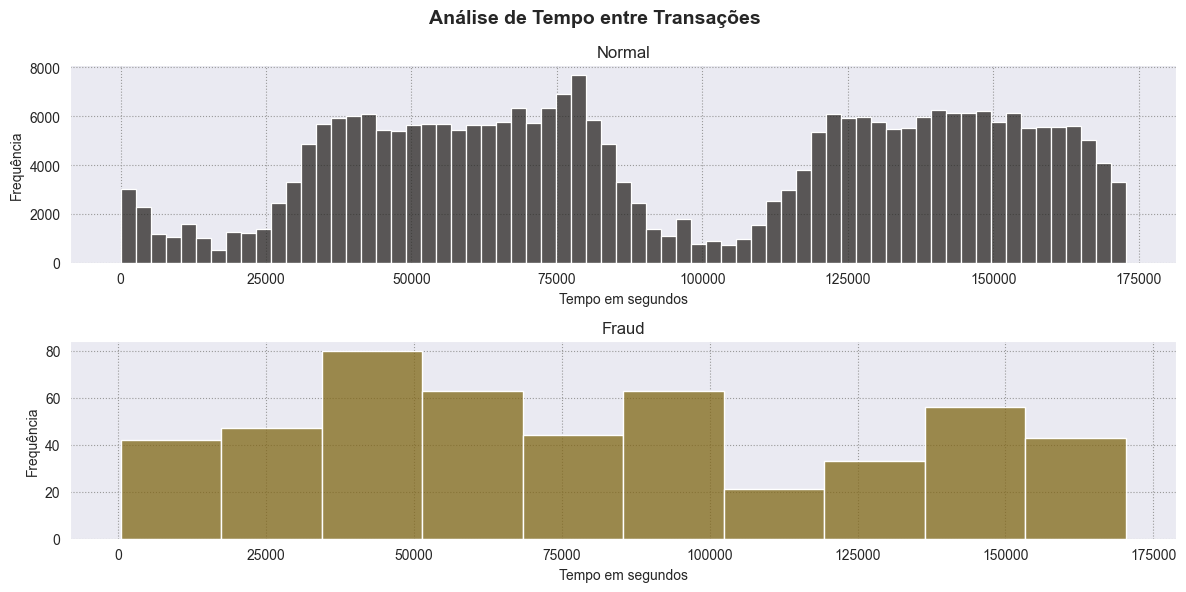

In [492]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,6))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_palette(sns.dark_palette("xkcd:golden", 8))
sns.histplot(data=df.Time.loc[df.Class == 0], kde=False, ax = ax[0], color=sns.color_palette()[0])
sns.histplot(data=df.Time.loc[df.Class == 1], kde=False, ax = ax[1], color=sns.color_palette()[3])
ax[0].set_xlabel('Tempo em segundos')
ax[0].set_ylabel('Frequência')
ax[0].set_title('Normal');

ax[1].set_xlabel('Tempo em segundos')
ax[1].set_ylabel('Frequência')
ax[1].set_title('Fraud');

fig.suptitle("Análise de Tempo entre Transações", fontsize=14, fontweight='bold')
plt.tight_layout()


Observação estatística da variável `Time`quando não há/há fraudes. É possível notar que quando há fraudes, a média e mediana são menores, o que sugere **menor espaço de tempo entre uma transação e outra**. Porém, num contexto geral, as diferenças são sutis.

In [493]:
# Não há fraudes
df.Time.loc[df.Class == 0].describe()

count    284315.000000
mean      94838.202258
std       47484.015786
min           0.000000
25%       54230.000000
50%       84711.000000
75%      139333.000000
max      172792.000000
Name: Time, dtype: float64

In [494]:
# Há fraudes
df.Time.loc[df.Class == 1].describe()

count       492.000000
mean      80746.806911
std       47835.365138
min         406.000000
25%       41241.500000
50%       75568.500000
75%      128483.000000
max      170348.000000
Name: Time, dtype: float64

A seguir um histograma para a variável `Amount`quando há fraudes e quando não há. Os resultados indicam que **transações normais** tendem a ter **valores mais elevados**, com média de 88,29 e mediana de 22,00, enquanto que transações fraudulentas tendem a ter valores menores, com média de 122,21 e mediana de 9,25.

Além disso, a amplitude de valores nas transações normais é muito maior do que nas transações fraudulentas. O valor máximo observado nas transações normais foi de 25.691,16, enquanto que nas transações fraudulentas foi de 2.125,87.

Esses resultados indicam que, em geral, as transações fraudulentas tendem a ser de valores mais baixos do que as transações normais. Isso pode ser explicado pelo fato de que transações fraudulentas são frequentemente realizadas de forma indiscriminada, visando obter lucros menores, mas em maior volume, enquanto que transações normais geralmente têm valores mais altos e são realizadas de forma mais seletiva, visando objetivos específicos.

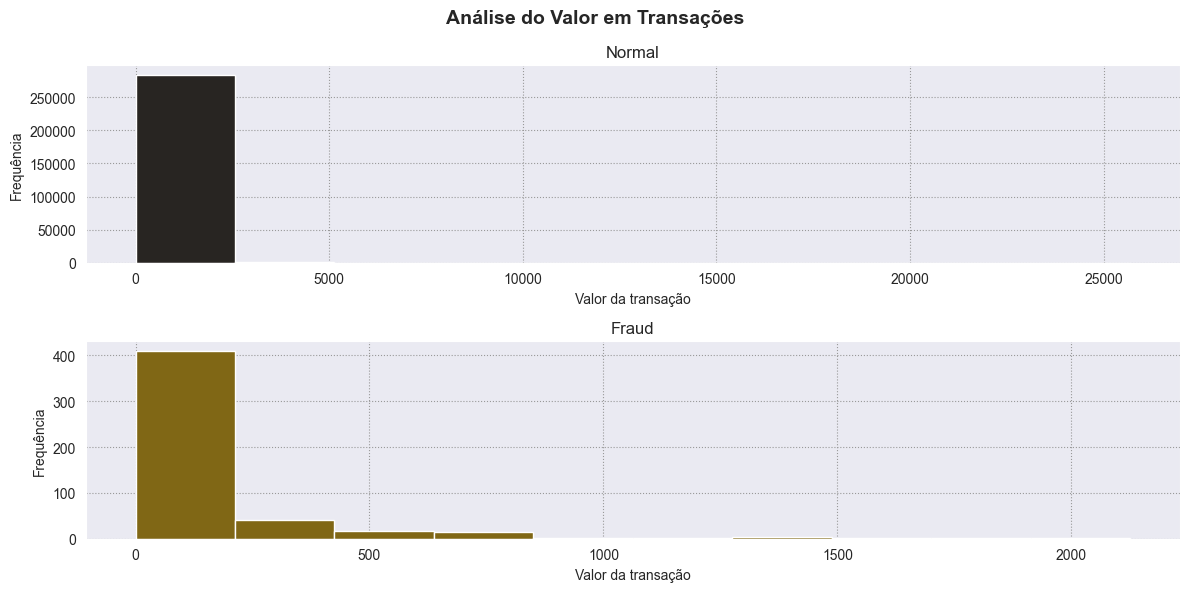

In [495]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,6))


ax[0].hist(df.Amount[df.Class == 0], color=sns.color_palette()[0])
ax[0].set_title('Normal')

ax[1].hist(df.Amount[df.Class == 1], color=sns.color_palette()[3])
ax[1].set_title('Fraud')

ax[0].set_xlabel('Valor da transação')
ax[0].set_ylabel('Frequência')

ax[1].set_xlabel('Valor da transação')
ax[1].set_ylabel('Frequência')

fig.suptitle("Análise do Valor em Transações", fontsize=14, fontweight='bold')
plt.tight_layout()


Observação estatística da variável `Amount`quando não há/há fraudes.

In [496]:
# Não há fraudes
df.Amount[df.Class == 0].describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [497]:
# Há fraudes
df.Amount[df.Class == 1].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Pode-se observar essa distribuição no boxplot abaixo.

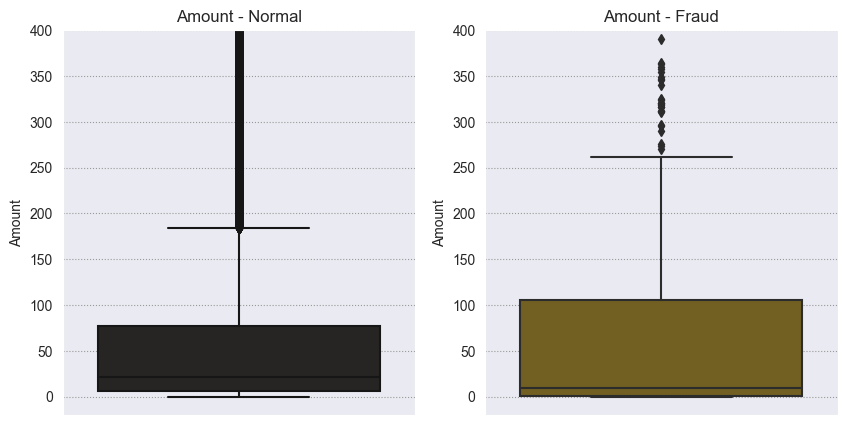

In [498]:
# verificar o conjunto de dados original
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_palette(sns.dark_palette("xkcd:golden", 8))
sns.boxplot(data = df.loc[df.Class == 0], y= 'Amount', ax = ax[0], color=sns.color_palette()[0])
sns.boxplot(data = df.loc[df.Class == 1], y= 'Amount', ax = ax[1], color=sns.color_palette()[3])
ax[0].set_title('Amount - Normal')
ax[1].set_title('Amount - Fraud')
ax[0].set_ylim(-20, 400)
ax[1].set_ylim(-20, 400)
plt.show()

Nas plotagens acima é fácil observar que há uma forte discrepância entre algumas variáveis, o que indica uma forte **presença de outliers**. Os outliers não necessariamente são realmente valores extremos inválidos, pois podem ser representativos de transações legítimas ou fraudulentas. Portanto, irei preparar os dados e analisá-los mais a fundo.



Iremos verificar se as variáveis `Time` e `Amount` têm alguma correlação plotando um gráfico de dispersão e uma matriz de correlação.

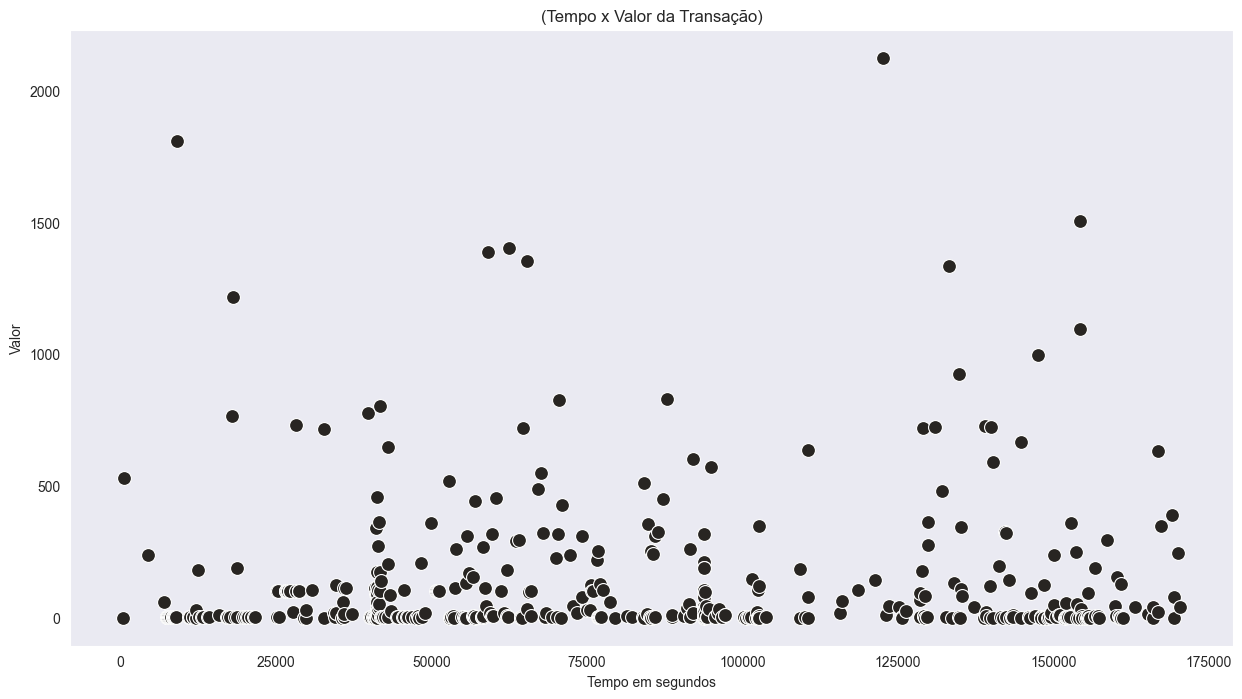

In [499]:
fig = plt.gcf()

fig.set_size_inches(15, 8)

ax = sns.scatterplot(data=df.loc[df.Class == 1], x="Time", y="Amount", s = 100)
ax.set(xlabel='Tempo em segundos', ylabel='Valor')
ax.set_title("(Tempo x Valor da Transação)")
ax.grid(False)

plt.show()

In [500]:
# criar uma matriz de correlação
corr_df = df[['Time', 'Amount']].corr(method='pearson');

# mostrar a matriz de correlação
display(corr_df);

,Time,Amount
Time,1.000000,-0.010596
Amount,-0.010596,1.000000


Obtemos uma correlação bastante fraca (-0.010), o que sugere que a relação entre as variáveis é pouco significativa.

De maneira resumida, pode-se observar que:
* Não há valores nulos no dataframe.
* As variáveis `time` e `amount` não estão normalizadas.
* Os dados estão extremamente desbalanceados.
* Transações normais tendem a ter valores maiores.

## Pré-processamento dos Dados


### Padronizar `Time` e `Amount`

O objetivo do pré-processamento de dados é garantir que as features estejam na mesma escala, garantindo um desempenho melhor do algoritmo de *machine learning*. Para normalizar as variáveis `Time` e `Amount` será utilizado o *StandardScaler*. Ele ajusta os dados para que tenham uma média zero e um desvio padrão de um.

In [501]:
# padronizar as colunas Time e Amount
df_clean = df.copy()
std_scaler = StandardScaler()
df_clean['std_amount'] = std_scaler.fit_transform(df_clean['Amount'].values.reshape(-1, 1))
df_clean['std_time'] = std_scaler.fit_transform(df_clean['Time'].values.reshape(-1, 1))
df_clean.drop(['Time', 'Amount'], axis=1, inplace=True)

# ver as primeiras entradas
df_clean.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,std_amount,std_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


### Divisão do Conjunto de Dados

Com a normalização adequada das variáveis, é necessário dividir o conjunto de dados em treinamento e validação. É importante que o modelo seja capaz de generalizar para evitar problemas como o *underfitting*, que ocorre quando o modelo tem baixo desempenho tanto no treinamento quanto na validação, ou o *overfitting*, que ocorre quando o modelo se adapta demasiadamente ao treinamento e não consegue generalizar para novos dados.

Existem vários métodos de divisão de dados disponíveis para evitar esses problemas. Neste caso, adotaremos a proporção de **70/15/15** para o conjunto de treinamento, validação e teste, respectivamente.

#### Separando o conjunto de teste

In [502]:
# criando o conjunto de teste
test = df_clean.sample(frac=0.15, random_state=0)

# verificando o conjunto
print(test.shape)
test.head()

(42721, 31)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,std_amount,std_time
183484,-0.323334,1.057455,-0.048341,-0.607204,1.259821,-0.091761,1.159101,-0.124335,-0.174640,-1.644401,...,-0.433890,-0.261613,-0.046651,0.211512,0.008297,0.108494,0.161139,0,-0.193306,0.652946
255448,-0.349718,0.932619,0.142992,-0.657071,1.169784,-0.733369,1.009985,-0.071069,-0.302083,-1.192404,...,-0.833209,-0.030360,0.490035,-0.404816,0.134350,0.076830,0.175562,0,-0.345313,1.314460
244749,-1.614711,-2.406570,0.326194,0.665520,2.369268,-1.775367,-1.139049,0.329904,0.903813,-0.219013,...,1.134489,0.965054,0.640981,-1.801998,-1.041114,0.286285,0.437322,0,0.030587,1.214140
63919,-2.477184,0.860613,1.441850,1.051019,-1.856621,2.078384,0.510828,-0.243399,-0.260691,0.133040,...,0.692245,0.150121,-0.260777,0.005183,-0.177847,-0.510060,-0.660533,0,0.878181,-0.924166
11475,1.338831,-0.547264,0.737389,-0.212383,-1.110039,-0.525744,-0.801403,-0.063672,0.997276,0.113386,...,-0.074719,0.067055,0.333122,0.379087,-0.268706,-0.002769,0.003272,0,-0.333239,-1.577551


In [503]:
# drop das linhas de teste
df = df_clean.drop(test.index)

# verificando o shape do df
df_clean.shape

(284807, 31)

In [504]:
# resetando o index dos conjuntos
df_clean.reset_index()
test.reset_index()

,index,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Class,std_amount,std_time
0,183484,-0.323334,1.057455,-0.048341,-0.607204,1.259821,-0.091761,1.159101,-0.124335,-0.174640,...,-0.433890,-0.261613,-0.046651,0.211512,0.008297,0.108494,0.161139,0,-0.193306,0.652946
1,255448,-0.349718,0.932619,0.142992,-0.657071,1.169784,-0.733369,1.009985,-0.071069,-0.302083,...,-0.833209,-0.030360,0.490035,-0.404816,0.134350,0.076830,0.175562,0,-0.345313,1.314460
2,244749,-1.614711,-2.406570,0.326194,0.665520,2.369268,-1.775367,-1.139049,0.329904,0.903813,...,1.134489,0.965054,0.640981,-1.801998,-1.041114,0.286285,0.437322,0,0.030587,1.214140
3,63919,-2.477184,0.860613,1.441850,1.051019,-1.856621,2.078384,0.510828,-0.243399,-0.260691,...,0.692245,0.150121,-0.260777,0.005183,-0.177847,-0.510060,-0.660533,0,0.878181,-0.924166
4,11475,1.338831,-0.547264,0.737389,-0.212383,-1.110039,-0.525744,-0.801403,-0.063672,0.997276,...,-0.074719,0.067055,0.333122,0.379087,-0.268706,-0.002769,0.003272,0,-0.333239,-1.577551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42716,229333,-0.330429,0.587057,0.635175,-0.619929,0.690199,-1.146289,0.914373,-0.158436,-0.160107,...,-0.540837,0.047329,-0.037745,-0.671478,0.119750,0.094611,0.173363,0,-0.348072,1.075452
42717,189242,-17.015895,-18.501723,-2.965763,5.989228,7.811563,-4.440128,-1.905238,-1.938201,3.276087,...,3.688960,11.360879,0.771200,2.274458,1.954516,6.507171,-4.075417,0,-0.327762,0.705507
42718,232656,0.044490,0.898231,0.306854,-0.587229,0.441139,-1.121860,1.039291,-0.231897,-0.108498,...,-0.535225,0.064659,0.050984,-0.476387,0.136342,0.250095,0.098383,0,-0.342475,1.104259
42719,174418,1.945191,-0.273317,-0.126410,0.436141,-0.841361,-1.026928,-0.323962,-0.216008,0.809408,...,-0.481833,0.466048,0.482353,-0.668233,0.198535,-0.033724,-0.033819,0,-0.257315,0.570483


Com o conjunto de teste devidamente separado, iremos criar o conjunto de treino e validação. Utilizaremos o teste para validar o modelo ao final.

#### Conjunto de treino e validação

In [505]:
# separar variáveis entre X e y
X = df_clean.drop('Class', axis=1)
y = df_clean['Class'] # variável alvo

# dividir o dataset entre treino e validação
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, test_size = 0.15)

## Balanceamento de dados

Um dataset que possua mais de 50% das entradas em uma classe já é considerado desbalanceado. A maioria dos algoritmos de aprendizado de máquina funcionam bem com conjuntos de dados equilibrados, uma vez que eles buscam otimizar a precisão geral da classificação ou medidas relacionadas. Para dados **desbalanceados**, os limites de decisões estabelecidos por padrão nos algoritmos tendem a ser **enviesados em torno da classe majoritária**. Portanto a **classe minoritária tende a ser classificada incorretamente.**

**No cenário apresentado, um falso positivo é preferível a um falso negativo**, pois as instituições financeiras sofrem mais prejuízos com transações indevidas do que o contrário. Para solucionar o problema, é necessário utilizar métricas que priorizem essa questão e tomar medidas para tratar o desbalanceamento dos dados. Uma maneira de corrigir o problema é utilizando técnicas de **sampling** ou amostragem, sendo divididas em **under-sampling** e **over-sampling**. 

O **under-sampling** consiste em **remover exemplos da classe majoritária** para tornar a proporção entre as classes mais equilibrada. Já o **over-sampling**, por sua vez, consiste em **gerar novos exemplos para a classe minoritári**a, de forma a aumentar sua representatividade no conjunto de dados.

Utilizaremos a técnica **ClusterCentroids** em **under-sampling** e **SMOTE** em **over-sampling**. Também será utilizado os modelos de *machine learning* **Decision Tree** e **Logistic Regression**.

### ClusterCentroids 

ClusterCentroids  é uma técnica de *under-sampling* em que a **classe majoritária** é agrupada em **clusters** e, em seguida, exemplos de cada cluster são selecionados aleatoriamente até que o conjunto de dados esteja equilibrado. A ideia por trás dessa técnica é que, se houver uma grande quantidade de exemplos da classe majoritária próximos uns aos outros, pode ser possível reduzir o número de exemplos da classe majoritária selecionando aleatoriamente apenas alguns exemplos de cada cluster, **sem perder informações importantes do conjunto de dados original**. 

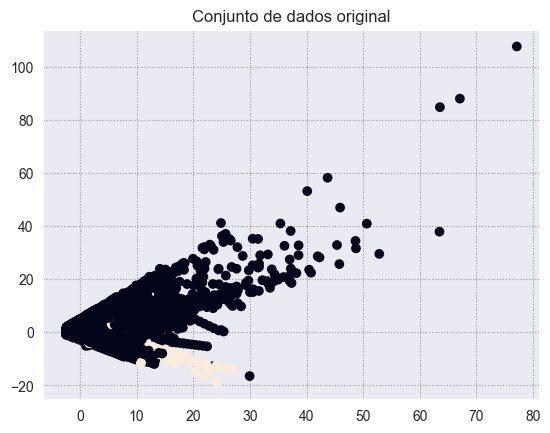

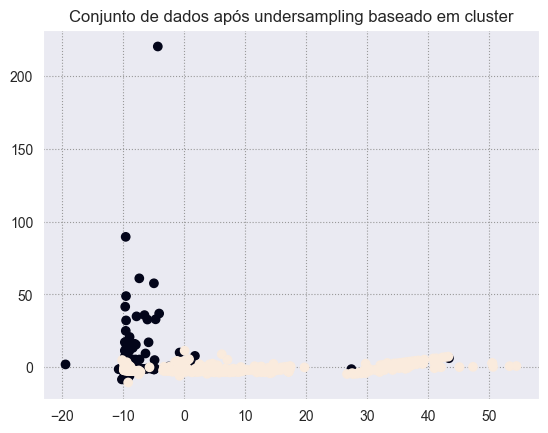

In [506]:
# Aplica a redução de dimensionalidade PCA para deixar o X_train em duas dimensões
pca = PCA(2)
X_train_vis = pca.fit_transform(X_train)

# Exibindo o conjunto de dados original
plt.scatter(X_train_vis[:, 0], X_train_vis[:, 1], c=y_train)
plt.title('Conjunto de dados original')
plt.show()

# Cria um objeto ClusterCentroids
cc = ClusterCentroids(sampling_strategy='auto', random_state=10)

# Aplica undersampling baseado em cluster
X_resampled, y_resampled = cc.fit_resample(X_train, y_train)

# Aplicando PCA para visualizar o conjunto de dados em 2 dimensões após o undersampling
X_resampled_vis = pca.fit_transform(X_resampled)

# Exibindo o conjunto de dados após o undersampling
plt.scatter(X_resampled_vis[:, 0], X_resampled_vis[:, 1], c=y_resampled)
plt.title('Conjunto de dados após undersampling baseado em cluster')
plt.show()


Ao utilizar a técnica under-sampling, **241249 amostras foram eliminadas** a fim de tornar o dataset balanceado.

In [507]:
# Visualizando o tamanho do conjunto de treinamento
print("Tamanho do y_train:", np.shape(y_train))

# Visualizando o tamanho do conjunto balanceado
print("Tamanho do y_resampled:", np.shape(y_resampled))

Tamanho do y_train: (242085,)
Tamanho do y_resampled: (836,)


In [508]:
# ver o balanceamento das classes
print(pd.Series(y_resampled).value_counts())
sns.set_palette(sns.dark_palette("xkcd:golden", 8))

0    418
1    418
Name: Class, dtype: int64


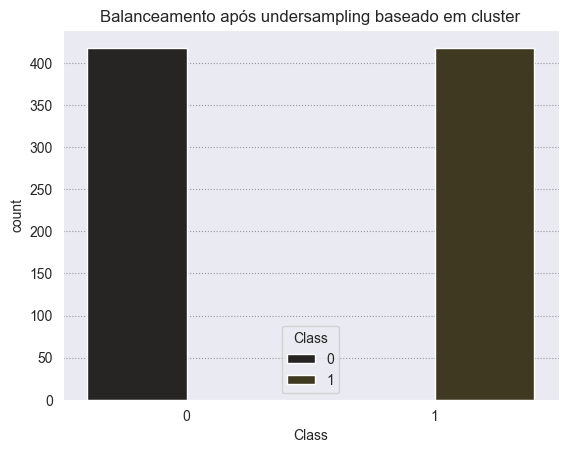

In [538]:
# plotar a nova distribuição de classes
sns.countplot(x=y_resampled, hue=y_resampled);
plt.title('Balanceamento após undersampling baseado em cluster')
plt.show();

### SMOTE

SMOTE (Synthetic Minority Over-sampling Technique) é uma técnica de **over-sampling** amplamente utilizada em problemas de classificação em que a classe minoritária é significativamente menor do que a classe majoritária. Essa técnica é útil porque muitos algoritmos de aprendizado de máquina são sensíveis ao desbalanceamento de classes e tendem a ter um desempenho pior quando a classe minoritária é sub-representada. A técnica funciona selecionando um exemplo da classe minoritária e encontrando os seus k vizinhos mais próximos. Em seguida, ela **cria novos exemplos sintéticos** interpolando aleatoriamente os atributos dos exemplos selecionados e adicionando-os ao conjunto de dados.

In [510]:
# Criando uma instância do SMOTE
smote = SMOTE()

# Balanceando os dados
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train, y_train)

Ao utilizar a técnica over-sampling **241249 foram criadas** a fim de balancear o dataset.

In [511]:
# Visualizando o tamanho do conjunto de treinamento
print("Tamanho do y_train:", np.shape(y_train))

# Visualizando o tamanho do conjunto balanceado
print("Tamanho do y_resampled:", np.shape(y_resampled_smote))

Tamanho do y_train: (242085,)
Tamanho do y_resampled: (483334,)


In [512]:
# ver o balanceamento das classes
print(pd.Series(y_resampled_smote).value_counts())
sns.set_palette(sns.dark_palette("xkcd:golden", 8))

0    241667
1    241667
Name: Class, dtype: int64


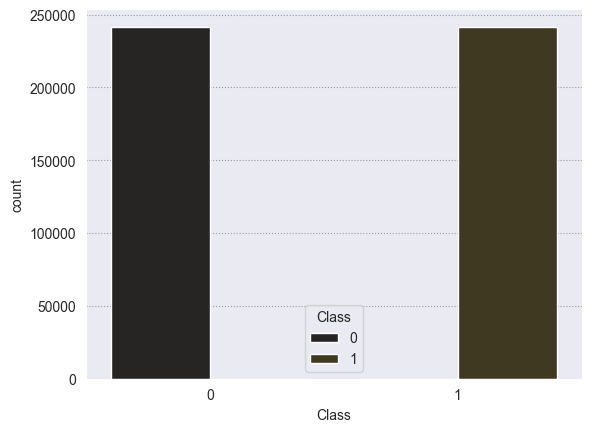

In [513]:
# plotar a nova distribuição de classes
sns.countplot(x=y_resampled_smote, hue=y_resampled_smote);

## Treinamento dos Algoritmos de *Machine Learning* aplicado às amostras

### Decision Tree 

Uma **árvore de decisão** para classificação é um modelo de aprendizado de máquina que usa um conjunto de regras de decisão para classificar uma instância em uma ou mais classes pré-definidas. Cada **nó interno** da árvore representa uma **pergunta** sobre uma das características dos dados de entrada, enquanto cada **folha** representa uma **classe de saída**. Durante o treinamento, o algoritmo de aprendizado constrói a árvore fazendo perguntas sucessivas para dividir o conjunto de dados de treinamento em subconjuntos menores, e enfim classificar o dado na saída adequada.

Abaixo, iremos realizar o aprendizado de máquina em Decision Tree utilizando o dataset balanceado pelo under-sampling e over-sampling respectivamente.

#### ClusterCentroid

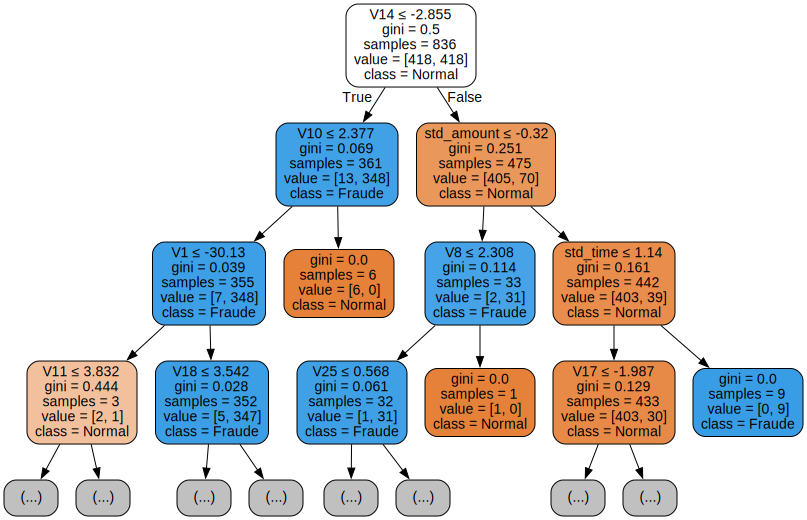

In [514]:
# Cria um objeto DecisionTreeClassifier, que retorna um Estimator
clf = tree.DecisionTreeClassifier()

# Realiza o aprendizado de máquina
clf = clf.fit(X_resampled, y_resampled)

# Definindo o caminho para o Graphviz
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz\bin'

dot_data = export_graphviz(clf, out_file=None, feature_names=X_resampled.columns, 
                           class_names=['Normal', 'Fraude'], filled=True, rounded=True, 
                           max_depth = 3, special_characters=True)

# Criando um objeto Graph a partir do arquivo .dot
graph = graphviz.Source(dot_data)

# Exibindo a árvore de decisão no notebook
display(graph)


In [515]:
# fazer as previsões em cima dos dados de teste
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

#### SMOTE

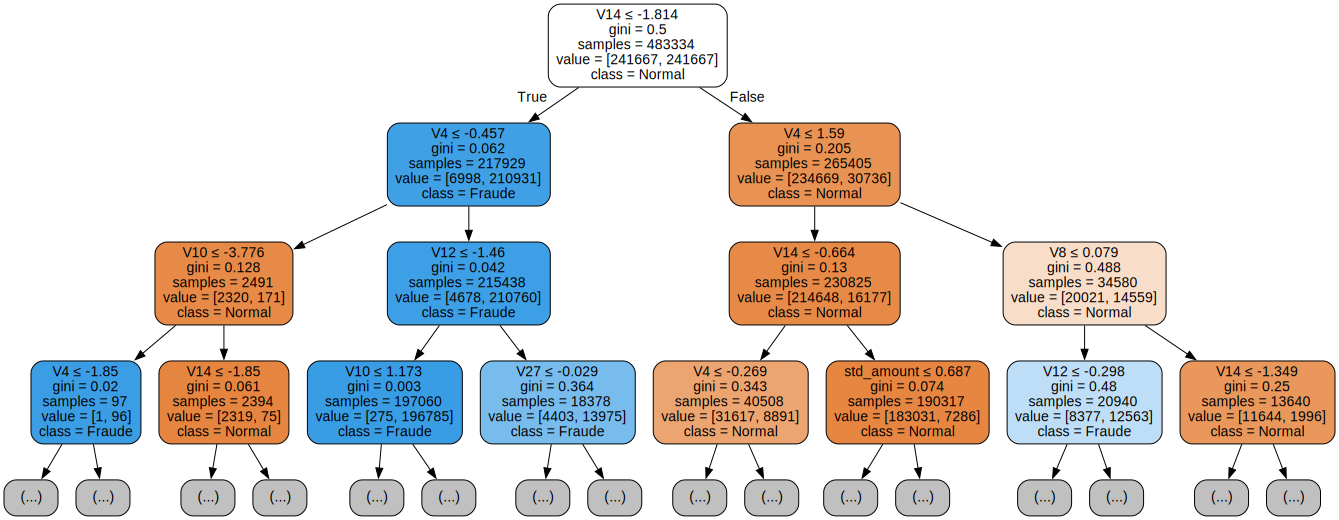

In [516]:
# Cria um objeto DecisionTreeClassifier, que retorna um Estimator
clf_smote = tree.DecisionTreeClassifier()

# Realiza o aprendizado de máquina
clf_smote = clf_smote.fit(X_resampled_smote, y_resampled_smote)

# Definindo o caminho para o Graphviz
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz\bin'

dot_data = export_graphviz(clf_smote, out_file=None, feature_names=X_resampled_smote.columns, 
                           class_names=['Normal', 'Fraude'], filled=True, rounded=True, 
                           max_depth = 3, special_characters=True)

# Criando um objeto Graph a partir do arquivo .dot
graph = graphviz.Source(dot_data)

# Exibindo a árvore de decisão no notebook
display(graph)


In [517]:
# fazer as previsões em cima dos dados de teste
y_pred_smote = clf_smote.predict(X_test)
y_prob_smote = clf_smote.predict_proba(X_test)

### Logistic Regression

A regressão logística é um modelo estatístico utilizado para problemas de classificação binária, ou seja, em que o objetivo é prever a probabilidade de um exemplo pertencer a uma das duas classes possíveis (por exemplo, sim ou não, positivo ou negativo, verdadeiro ou falso). O modelo de regressão logística utiliza a função logística para transformar uma variável de entrada linear em uma probabilidade. A função logística é uma função sigmoide que retorna valores entre 0 e 1. Essa probabilidade é então comparada com um limiar para decidir em qual classe o exemplo deve ser classificado.

Abaixo, iremos realizar o aprendizado de máquina em Logistic Regression utilizando o dataset balanceado pelo under-sampling e over-sampling respectivamente.

#### ClusterCentroid

In [518]:
# instanciar e treinar um modelo de Regressão Logística
np.random.seed(2)
model = LogisticRegression()
model.fit(X_resampled, y_resampled);

C:\Users\danie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [519]:
# fazer as previsões em cima dos dados de teste
y_pred_lr = model.predict(X_test)
y_proba_lr = model.predict_proba(X_test)

#### SMOTE

In [520]:
# instanciar e treinar um modelo de Regressão Logística
np.random.seed(2)
model_smote = LogisticRegression()
model_smote.fit(X_resampled_smote, y_resampled_smote);

In [521]:
# fazer as previsões em cima dos dados de teste
y_pred_lr_smote = model_smote.predict(X_test)
y_proba_lr_smote = model_smote.predict_proba(X_test)

## Previsões no Conjunto de Validação
<p align = "center">
<img src="Arquivos/robot.jpg" width=80%>
</p>

Para validar se tivemos um bom resultado com o treinamento, utilizaremos algumas **métricas** para modelos de classificação, como **matriz de confusão, acurácia, recall, precision, F-1 score, support e AUC.**

A **matriz de confusão** é uma tabela que mostra a relação entre as previsões de um modelo e as classes reais dos exemplos no conjunto de dados, e possui quatro elementos:

* *Verdadeiro positivo (TP): exemplo que foi classificado corretamente como positivo pelo modelo.*
* *Falso positivo (FP): exemplo que foi classificado incorretamente como positivo pelo modelo, mas que na verdade é negativo.*
* *Falso negativo (FN): exemplo que foi classificado incorretamente como negativo pelo modelo, mas que na verdade é positivo.*
* *Verdadeiro negativo (TN): exemplo que foi classificado corretamente como negativo pelo modelo.*

**Precision (precisão)**: é a **proporção de verdadeiros positivos (TP) sobre todos os exemplos classificados como positivos** (TP + FP). Em outras palavras, é a proporção de exemplos que o modelo classificou corretamente como positivos em relação a todos os exemplos que ele classificou como positivos. Uma precisão de 1.0 significa que todos os exemplos classificados como positivos foram verdadeiros positivos.

**Recall (revocação):** é a proporção de verdadeiros positivos (TP) sobre todos os exemplos que realmente são positivos (TP + FN). Em outras palavras, é a **proporção de exemplos positivos que o modelo classificou corretamente em relação a todos os exemplos positivos.** Um recall de 1.0 significa que todos os exemplos positivos foram classificados corretamente como positivos.

**F1-score:** é uma média harmônica ponderada da precisão e do recall, onde a **pontuação F1 alcança seu melhor valor em 1 e o pior em 0.** Um F1-score de 1.0 significa que a precisão e o recall estão perfeitos.

**Support (suporte):** é o número de exemplos no conjunto de dados que pertencem àquela classe.

**Acurácia:** é a proporção de exemplos classificados corretamente em relação ao número total de exemplos.

**AUC (área sob a curva):** é uma medida de desempenho usada para problemas de classificação binária. É a área sob a curva ROC (receiver operating characteristic), que é um gráfico que mostra a relação entre a taxa de verdadeiros positivos e a taxa de falsos positivos para diferentes limiares de classificação. **Um valor de AUC de 1.0 significa que o modelo é capaz de distinguir perfeitamente entre as duas classes.**

### Decision Tree

### Under-sampling

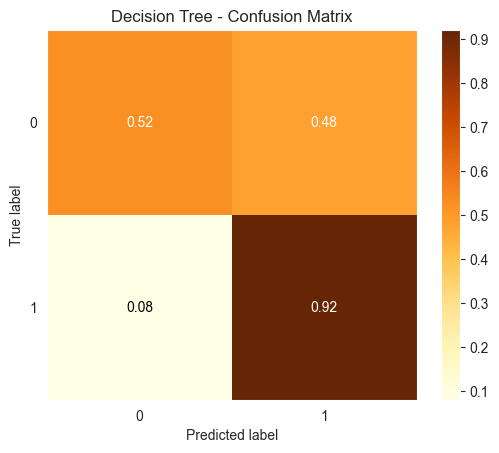

In [522]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, cmap = 'YlOrBr')
plt.title("Decision Tree - Confusion Matrix");

Com a matriz de confusão pode-se observar que o modelo teve um bom desempenho ao classificar fraudes, com 92% das fraudes preditas corretamente. Contudo, em transações normais o desempenho foi aquém do esperado, pois apenas 52% foram classificadas corretamente.

In [523]:
# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred)))

# imprimir a área sob da curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9997    0.5187    0.6830     42648
           1     0.0033    0.9189    0.0066        74

    accuracy                         0.5194     42722
   macro avg     0.5015    0.7188    0.3448     42722
weighted avg     0.9980    0.5194    0.6819     42722

Acurácia: 0.5194

AUC: 0.7188



Neste tipo de problema, originalmente desbalanceado, a **acurácia** não é uma métrica adequada, mas obtivemos **51%** de acerto geral. A **área sob a curva ROC** do modelo é de **0.7188**, o que indica que o modelo **conseguiu distinguir razoavelmente bem** entre as duas classes. Para a **classe 1**, o **recall é muito alto**, de 0.9189, o que significa que o modelo identificou a grande maioria das fraudes, contudo para a **classe 0** o valor é **mediano**, apenas 0.5187. Também é possível observar que a classe 0 teve 42648 exemplos, enquanto a classe 1 teve apenas 74 exemplos.

### Over-sampling

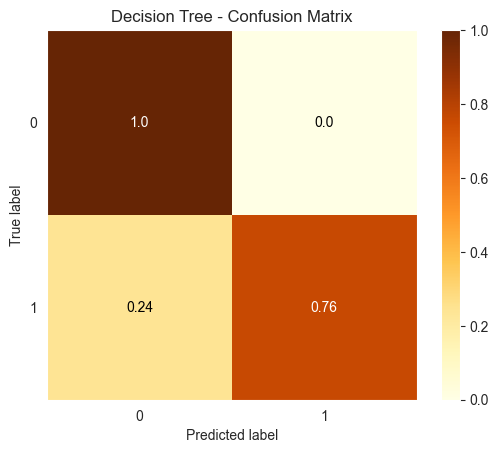

In [524]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred_smote, normalize=True, cmap = 'YlOrBr')
plt.title("Decision Tree - Confusion Matrix");

In [525]:
# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred_smote, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred_smote)))

# imprimir a área sob da curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred_smote)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9996    0.9978    0.9987     42648
           1     0.3784    0.7568    0.5045        74

    accuracy                         0.9974     42722
   macro avg     0.6890    0.8773    0.7516     42722
weighted avg     0.9985    0.9974    0.9979     42722

Acurácia: 0.9974

AUC: 0.8773



A combinação de **over-sampling com Decision Tree** retornou um **AUC maior, cerca de 0.88**, o que representação melhor distinção entre classes. Contudo, a classificação de transações fraudulentas foi menor, representando 76%. O desempenho de transações normais foi muito alto, 100% foi classificado corretamente.

### Logistic Regression

### Under-sampling

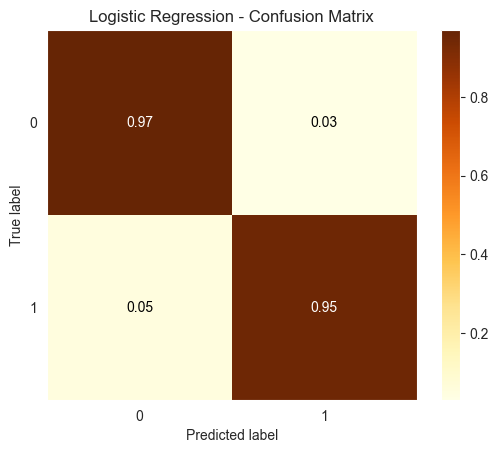

In [526]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred_lr, normalize=True, cmap = 'YlOrBr')
plt.title("Logistic Regression - Confusion Matrix");

In [527]:
# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred_lr, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred_lr)))

# imprimir a área sob da curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred_lr)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9999    0.9678    0.9836     42648
           1     0.0485    0.9459    0.0923        74

    accuracy                         0.9678     42722
   macro avg     0.5242    0.9569    0.5380     42722
weighted avg     0.9983    0.9678    0.9821     42722

Acurácia: 0.9678

AUC: 0.9569



De modo geral, o modelo possuiu um ótimo desempenho. O AUC está em 0.95, o que indica que foi possível distinguir bem entre as duas classes. 95% das fraudes foram classificadas corretamente, bem como 97% das transações normais. 

### Over-sampling

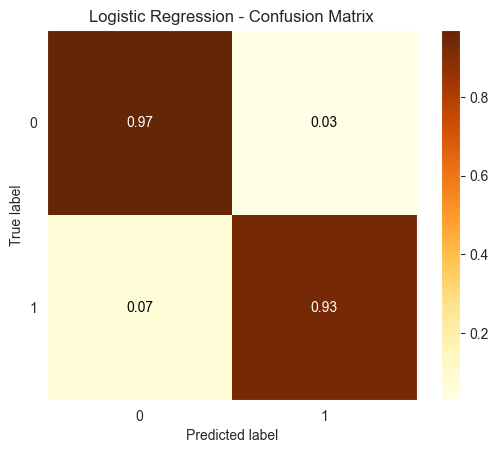

In [528]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred_lr_smote, normalize=True, cmap = 'YlOrBr')
plt.title("Logistic Regression - Confusion Matrix");

In [529]:
# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred_lr_smote, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred_lr_smote)))

# imprimir a área sob da curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred_lr_smote)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9999    0.9745    0.9870     42648
           1     0.0597    0.9324    0.1123        74

    accuracy                         0.9745     42722
   macro avg     0.5298    0.9535    0.5497     42722
weighted avg     0.9983    0.9745    0.9855     42722

Acurácia: 0.9745

AUC: 0.9535



Over-sampling e Logistic Regression trouxe um resultado semelhante ao under-sampling e Logistic Regression. Os dois modelos tiveram ótimo desempenho, com AUC em torno de 0.95. Com over-sampling, 93% das transações fraudulentas foram classificadas corretamente, contra 95% do under-sampling. Concomitantemente, nos dois modelos 97% das transações normais foram corretamente classificadas.

## Avaliação do Modelo Utilizando os Dados de Teste

No começo do projeto, realizamos um split nos dados para que tivéssemos 3 conjuntos: Um de treino, um de validação e um de teste. Agora que já exploramos e preparamos os dados, instaciamos o modelo e fizemos previsões no conjunto de validação, é hora de descobrirmos o potencial desse simples modelo com os dados de teste.

In [530]:
# separar variáveis entre X e y
X_test = test.drop('Class', axis=1)
y_test = test['Class']

### Decision Tree - Under-sampling e Over-sampling

Em geral, observamos um **desempenho melhor** no conjunto de teste em comparação ao de validação, embora ainda seja semelhante. No caso do balanceamento usando **under-sampling**, o modelo apresentou um **recall** de 0.99 para a classe minoritária (fraudes) e 0,52 para a classe majoritária, com **AUC** em torno de 0,75. Em comparação, no conjunto de validação, os resultados foram de 0,92, 0,52 e 0,71, respectivamente.

Já no balanceamento utilizando **over-sampling**, o modelo apresentou recall de 1 para a classe majoritária e 0,93 para a classe minoritária, representando um aumento significativo em relação aos resultados obtidos no conjunto de validação (1 e 0,76, respectivamente). Além disso, o **AUC** aumentou de 0,87 para 0,96.

In [531]:
# Under-sampling
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)

# Over-sampling 
y_pred_smote = clf_smote.predict(X_test)
y_prob_smote = clf_smote.predict_proba(X_test)

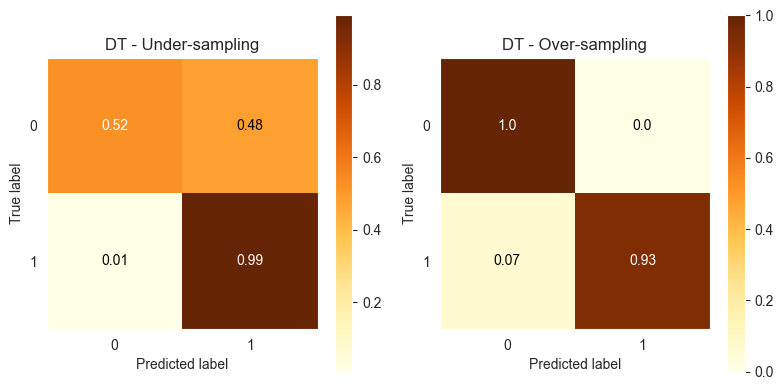

In [544]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, cmap = 'YlOrBr', ax = ax[0])
skplt.metrics.plot_confusion_matrix(y_test, y_pred_smote, normalize=True, cmap = 'YlOrBr', ax = ax[1])

ax[0].set_title("DT - Under-sampling")
ax[1].set_title("DT - Over-sampling")

plt.tight_layout();

In [533]:
# imprimir a área sob da curva
print("AUC DT - Under-sampling: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))
print("AUC DT - Over-sampling: {:.4f}\n".format(roc_auc_score(y_test, y_pred_smote)))

AUC DT - Under-sampling: 0.7540

AUC DT - Over-sampling: 0.9660



### Logistic Regression - Under-sampling e Over-sampling

No caso da **Logistic Regression** utilizando **under-sampling**, foram obtidas métricas semelhantes às anteriores, com exceção do **AUC**, que apresentou um **leve aumento** de 0,9569 para 0,9573, embora pouco significativo. Por outro lado, no caso do **over-sampling**, houve um **aumento** significativo no **recall da classe minoritária**, de 0,93 para 0,96, e no **AUC**, que aumentou de 0,9535 para 0,9670.

Em geral, todos os modelos utilizando a regressão logística apresentaram um **bom desempenho**, com AUC acima de 0,95 e recall elevado para a classe minoritária, o que indica que o modelo é capaz de detectar com precisão as transações fraudulentas.

In [534]:
# fazer as previsões em cima dos dados de teste
y_pred_lr = model.predict(X_test)
y_proba_lr = model.predict_proba(X_test)

# fazer as previsões em cima dos dados de teste
y_pred_lr_smote = model_smote.predict(X_test)
y_proba_lr_smote = model_smote.predict_proba(X_test)

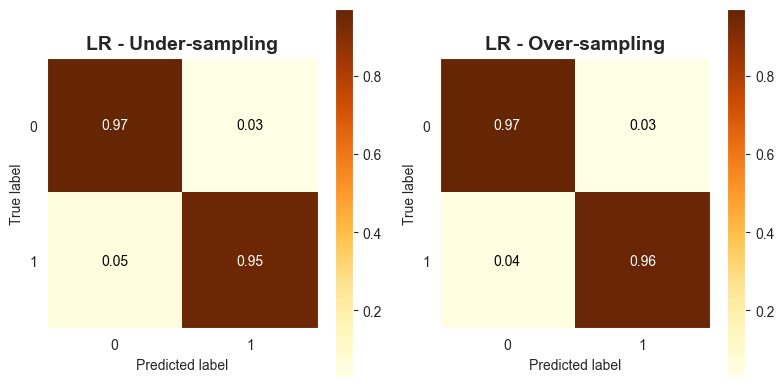

In [542]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
skplt.metrics.plot_confusion_matrix(y_test, y_pred_lr, normalize=True, cmap = 'YlOrBr', ax = ax[0])
skplt.metrics.plot_confusion_matrix(y_test, y_pred_lr_smote, normalize=True, cmap = 'YlOrBr', ax = ax[1])

ax[0].set_title("LR - Under-sampling")
ax[1].set_title("LR - Over-sampling")

plt.tight_layout();

In [536]:
# imprimir a área sob da curva
print("AUC LR - Under-sampling: {:.4f}\n".format(roc_auc_score(y_test, y_pred_lr)))
print("AUC LR - Over-sampling: {:.4f}\n".format(roc_auc_score(y_test, y_pred_lr_smote)))

AUC LR - Under-sampling: 0.9573

AUC LR - Over-sampling: 0.9670



## Conclusão

Com base nas análises realizadas, pode-se concluir que a escolha do **modelo de classificação e da técnica de balanceamento de classes** é **fundamental** para obter um **bom desempenho** na detecção de fraudes em transações financeiras. Foram avaliados dois tipos de técnicas de balanceamento de classes (under-sampling e over-sampling) em conjunto com dois modelos de classificação (Decision Tree e Logistic Regression). A **regressão logística** mostrou-se uma escolha adequada para o problema, apresentando **desempenho superior** em relação à **Decision Tree**, que obteve menor AUC e recall para a classe minoritária.

As técnicas de **balanceamento** de classes se mostraram **eficazes** na melhoria do desempenho dos modelos, especialmente o **over-sampling**, que apresentou o **melhor desempenho geral** em termos de recall para a classe minoritária e AUC. No entanto, o under-sampling também apresentou resultados promissores, com um recall mais alto para a classe minoritária em comparação com o over-sampling.

Os modelos que utilizaram **Logistic Regression** apresentaram um **desempenho superior** em termos de **AUC**, com valores próximos a 0,95. O modelo que utilizou under-sampling e Logistic Regression obteve um recall mais alto para a classe minoritária (fraudes) em comparação com o modelo que utilizou over-sampling e Logistic Regression (95% versus 93%, respectivamente), mas o desempenho geral dos dois modelos foi muito semelhante.

Por outro lado, o modelo **Decision Tree** apresentou um **desempenho inferior** em relação aos modelos de Logistic Regression, com AUC em torno de 0,72 e recall de apenas 0,9189 para a classe minoritária. Além disso, observou-se um desempenho inferior com under-sampling em relação à precisão, mas com over-sampling, esse problema não foi observado.

Em resumo, a **escolha** cuidadosa do **modelo de classificação** e da **técnica de balanceamento** de classes é **crucial** para obter um bom **desempenho na detecção de fraudes**** em transações financeiras. A **regressão logística** mostrou ser uma **boa escolha** para esse problema, e o **balanceamento das classes** pode ajudar a **melhorar o desempenho do modelo** na detecção de fraudes.